# Macro F1 analysis

In [1]:
import pickle
import analysis_utils
import plot_utils
from collections import defaultdict, OrderedDict
import math
from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
from scipy.stats import entropy
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


sns.set_style("whitegrid")

In [3]:
debug=False

### 1) Load data from BIN files

In [4]:
#wes_title='wes2015'
n3_title='n3'
aida_title='aida'
#rss_title='rss500'
#reuters_title='reuters128'
titles=[aida_title, n3_title]# rss_title, reuters_title]#, wes_title]
systems=['agdistis', 'spotlight', 'wat']

In [5]:
### Load data from disk
system_data_articles={}
for system in systems:
    system_data_articles[system]={}
    for data_title in titles:
        with open('bin/%s_%s.bin' % (data_title, system), 'rb') as outfile:
            system_data_articles[system][data_title]=pickle.load(outfile)

#### [DEBUG-only] Store agdistis output to a file

In [6]:
if debug:
    with open('debug/agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

**1.1. Pick dataset**

In [7]:
system_articles = {}

for system in systems:
    system_articles[system]=set()
    for data_title in titles: 
        system_articles[system] |= system_data_articles[system][data_title]

**1.2. Normalize AGDISTIS NILs given as custom AKSW URIs **

In [8]:
for article in system_articles['agdistis']:
    for mention in article.entity_mentions:
        if mention.sys_link.startswith('http://aksw.org/'):
            mention.sys_link = '--NME--'


**1.3.Normalize forms to lower-case (disabled for now)**

In [9]:
if debug:
    for system in systems:
        for article in system_articles[system]:
            for mention in article.entity_mentions:
                mention.mention=mention.mention.lower()
                print(mention.mention)

### 2) Performance

#### 2.1. Overall

<span style="background-color:lightgreen">Section 5.1. of the paper</span>


In [10]:
def overall_performance_macro_prf(articles, skip_nils=True, skip_nonnils=False):
    """
    Compute overall macro precision, recall and F1 of a system.
    """
    tp=defaultdict(int)
    fn=defaultdict(int)
    fp=defaultdict(int)
    all_tuples=set()
    for article in articles:
            for entity in article.entity_mentions:
                    if skip_nils and entity.gold_link=='--NME--':
                            continue
                    if skip_nonnils and entity.gold_link!='--NME--':
                            continue
                    gold_tuple = (entity.mention, entity.gold_link)
                    sys_tuple = (entity.mention, entity.sys_link)
                    all_tuples.add(gold_tuple)
                    all_tuples.add(sys_tuple)
                    if entity.gold_link==entity.sys_link:
                            tp[gold_tuple]+=1
                    else:
                            if entity.sys_link!='--NME--':
                                    fp[sys_tuple]+=1
                            if entity.gold_link!='--NME--':
                                    fn[gold_tuple]+=1
    p={}
    r={}
    f1={}
    for t in all_tuples:
        if tp[t]+fp[t]:
            p[t]=tp[t]/(tp[t]+fp[t])
        else:
            p[t]=0
        if tp[t]+fn[t]:
            r[t]=tp[t]/(tp[t]+fn[t])
        else:
            r[t]=0
        if p[t]+r[t]:
            f1[t]=2*p[t]*r[t]/(p[t]+r[t])
        else:
            f1[t]=0


    return p,r,f1

In [11]:
def compute_macro_prf_on_selection(p, r, f1, forms_set=None):
    """
    Compute macro precision, recall and F1 of a system on a predefined subset of all forms.
    """
    p_sub={}
    r_sub={}
    f1_sub={}
    for t in f1.keys():
        if not forms_set or t[0] in forms_set:
            p_sub[t]=p[t]
            r_sub[t]=r[t]
            f1_sub[t]=f1[t]
    p_mean = np.mean(list(p_sub.values()))
    r_mean = np.mean(list(r_sub.values()))
    f1_mean = np.mean(list(f1_sub.values()))
    return p_mean, r_mean, f1_mean

In [12]:
skip_nils=True
skip_nonnils=False

In [13]:
p={}
r={}
f1={}

for system in systems:
    print(system.upper())
    p[system], r[system], f1[system]=overall_performance_macro_prf(system_articles[system], 
                                               skip_nils, 
                                               skip_nonnils)
    print(compute_macro_prf_on_selection(p[system], r[system], f1[system]))

AGDISTIS
(0.4417849905471271, 0.4531041394119532, 0.44334356751405646)
SPOTLIGHT
(0.5279784587035815, 0.5292368992810023, 0.5240556015600752)
WAT
(0.48811317288239353, 0.4516077106943315, 0.4594869071866488)


#### 2.2. Only forms that are interpretted as NILs and not-NILs

In [14]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_macro_prf_on_selection(p[system], r[system], f1[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    #all_sys_accs[system]['forms with nils & non-nils']=nn_f_acc
#    scores.append(['forms with nils & non-nils', system, nn_f_acc])

agdistis (0.13298914543333692, 0.1430236106207644, 0.13481274068142843)
spotlight (0.29287016761388623, 0.2932371098267085, 0.2793184614888732)
wat (0.339079676043976, 0.30940602896337094, 0.31042433198479885)


#### 2.3. Only ambiguous forms

In [15]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_macro_prf_on_selection(p[system], r[system], f1[system], ambiguous_forms)
    print(system, amb_f_acc)
#    all_sys_accs[system]['ambiguous forms']=amb_f_acc
#    scores.append(['ambiguous forms', system, amb_f_acc])

agdistis (0.12492681833870647, 0.21962944718616986, 0.14433782344579768)
spotlight (0.34512192055437224, 0.39012595936644706, 0.3430179837818785)
wat (0.27145765036234554, 0.25089295262995026, 0.24063473532797675)


### 3) Prepare the data needed to compare frequency/popularity and performance

**3.1. Compute P, R and F1 per form and instance**

In [16]:
all_forms=set()
for article in system_articles['agdistis']:
    for entity in article.entity_mentions:
        if skip_nils and entity.gold_link=='--NME--':
            continue
        all_forms.add(entity.mention)

In [17]:
prec_by_form = {system: defaultdict(dict) for system in systems}
recall_by_form = {system: defaultdict(dict) for system in systems}
f1_by_form = {system: defaultdict(dict) for system in systems}

for system in systems:
    for form in ambiguous_forms:
        prf = compute_macro_prf_on_selection(p[system], r[system], f1[system], {form})
        print(form, prf)
        prec_by_form[system][form]=prf[0]
        recall_by_form[system][form]=prf[1]
        f1_by_form[system][form]=prf[2]

Rabobank (0.038461538461538464, 0.5, 0.07142857142857144)
Leicester (0.1372549019607843, 0.3333333333333333, 0.19444444444444445)
PITTSBURGH (0.0, 0.0, 0.0)
World Cup (0.0, 0.0, 0.0)
Vatican (0.14814814814814814, 0.3333333333333333, 0.2051282051282051)
Indonesia (0.423728813559322, 0.5, 0.4587155963302752)
Volkswagen AG (0.375, 0.5, 0.42857142857142855)
Mobil (0.0, 0.0, 0.0)
Charlton (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Luxembourg (0.4166666666666667, 0.5, 0.45454545454545453)
Israel (0.49537037037037035, 0.5, 0.49767441860465117)
Austrian (0.0, 0.0, 0.0)
CINCINNATI (0.013888888888888888, 0.3333333333333333, 0.02666666666666666)
Georgia (0.041666666666666664, 0.25, 0.07142857142857142)
Bulgaria (0.4666666666666667, 0.5, 0.4827586206896552)
Australians (0.0, 0.0, 0.0)
Sutjeska (0.375, 0.5, 0.42857142857142855)
San Francisco (0.35714285714285715, 0.5, 0.41666666666666663)
San Diego (0.2916666666666667, 0.5, 0.3684210526315789)
Finance (0.0, 0.0, 0.0)
Greens (0.0, 

European Cup (0.0, 0.0, 0.0)
JACKSONVILLE (0.16666666666666666, 0.5, 0.25)
Hamilton (0.0, 0.0, 0.0)
Security Council (0.041666666666666664, 0.5, 0.07692307692307693)
St Gallen (0.16666666666666666, 0.5, 0.25)
Reading (0.3333333333333333, 0.13333333333333333, 0.1904761904761905)
Spaniard (0.0, 0.0, 0.0)
North (0.0, 0.0, 0.0)
Montenegrin (0.0, 0.0, 0.0)
Berlin (0.4807692307692308, 0.5, 0.49019607843137253)
Red Star (0.0, 0.0, 0.0)
BALTIMORE (0.0392156862745098, 0.3333333333333333, 0.07017543859649122)
Palestinian (0.0, 0.0, 0.0)
Sydney (0.19444444444444445, 0.3333333333333333, 0.24561403508771928)
Martinez (0.0, 0.0, 0.0)
Cameroon (0.25, 0.5, 0.3333333333333333)
JAPAN (0.16666666666666666, 0.5, 0.25)
LOS ANGELES (0.07777777777777778, 0.3333333333333333, 0.12612612612612611)
Newcastle (0.25, 0.21153846153846154, 0.22916666666666666)
HARTFORD (0.08333333333333333, 0.3333333333333333, 0.13333333333333333)
Ulsan (0.08333333333333333, 0.5, 0.14285714285714285)
Wall Street (0.15384615384615385

West (0.0, 0.0, 0.0)
Latvia (0.4375, 0.5, 0.4666666666666667)
Indiana (0.375, 0.5, 0.42857142857142855)
Gulf (0.0, 0.0, 0.0)
Eugene (0.25, 0.5, 0.3333333333333333)
Botswana (0.16666666666666666, 0.5, 0.25)
South African (0.21428571428571427, 0.25, 0.23076923076923075)
Kawasaki (0.0, 0.0, 0.0)
Briton (0.0, 0.0, 0.0)
Labour Day (0.2, 0.5, 0.28571428571428575)
NEW JERSEY (0.0, 0.0, 0.0)
POLAND (0.25, 0.5, 0.3333333333333333)
Italy (0.3231083844580777, 0.3333333333333333, 0.328141225337487)
Vancouver (0.375, 0.5, 0.42857142857142855)
Rangers (0.38461538461538464, 0.5, 0.4347826086956522)
Vaduz (0.06666666666666667, 0.3333333333333333, 0.11111111111111112)
Burundi (0.4, 0.5, 0.4444444444444445)
NORTHERN IRELAND (0.0, 0.0, 0.0)
Hamburg (0.08333333333333333, 0.3333333333333333, 0.13333333333333333)
BOSTON (0.027777777777777776, 0.25, 0.049999999999999996)
BULGARIA (0.25, 0.5, 0.3333333333333333)
Valencia (0.16666666666666666, 0.5, 0.25)
New York-based (0.0, 0.0, 0.0)
Islamic (0.0, 0.0, 0.0)
D

KANSAS CITY (0.75, 0.5673076923076923, 0.6060606060606061)
Leeds (0.5, 0.46153846153846156, 0.47916666666666663)
Chile (0.4041666666666667, 0.44, 0.4111111111111111)
Kentucky (0.15, 0.25, 0.18749999999999997)
Williams (0.4090909090909091, 0.5, 0.45)
Ethiopia (1.0, 1.0, 1.0)
Arrows (0.0, 0.0, 0.0)
Telfer (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Sudan (1.0, 1.0, 1.0)
Verona (1.0, 1.0, 1.0)
Toronto (0.2857142857142857, 0.3333333333333333, 0.1875)
Commonwealth (1.0, 1.0, 1.0)
VANCOUVER (0.13333333333333333, 0.3333333333333333, 0.1904761904761905)
Western (0.2916666666666667, 0.2916666666666667, 0.2916666666666667)
Ducati (0.4375, 0.5, 0.4666666666666667)
Syrian (0.22727272727272727, 0.5, 0.3125)
Senate (0.25, 0.5, 0.3333333333333333)
Pontypridd (0.25, 0.5, 0.3333333333333333)
Milwaukee (0.0, 0.0, 0.0)
Costa Rica (0.8333333333333333, 0.975, 0.8871794871794871)
Charleston (1.0, 1.0, 1.0)
San Marino (1.0, 1.0, 1.0)
Detroit (0.25, 0.1388888888888889, 0.17857142857142858)
Ha

Kassala (0.25, 0.5, 0.3333333333333333)
Mauritius (0.8, 0.8, 0.7499999999999999)
AUSTRIA (0.875, 0.8333333333333333, 0.8285714285714285)
MONTREAL (0.03571428571428571, 0.3333333333333333, 0.06451612903225805)
NASA (0.25, 0.5, 0.3333333333333333)
Chester-le-Street (0.25, 0.5, 0.3333333333333333)
OLYMPIC (0.0, 0.0, 0.0)
AUSTRALIA (0.025, 0.2, 0.04444444444444444)
ABC (0.0, 0.0, 0.0)
Romanian (0.4, 0.5, 0.4444444444444445)
Atlanta (0.1375, 0.2, 0.16296296296296295)
Damascus (0.07142857142857142, 0.5, 0.125)
Chesterfield (0.2, 0.25, 0.22222222222222224)
New York (0.15208333333333335, 0.2616279069767442, 0.06889564336372847)
Seychelles (0.125, 0.5, 0.2)
Wash (0.25, 0.5, 0.3333333333333333)
IRA (1.0, 1.0, 1.0)
Charleroi (0.5416666666666666, 0.6666666666666666, 0.5897435897435898)
French (0.19714285714285715, 0.1623529411764706, 0.17806451612903226)
St Louis (0.375, 0.5, 0.42857142857142855)
DENVER (0.5, 0.5, 0.5)
HOUSTON (0.014285714285714287, 0.14285714285714285, 0.025974025974025976)
Johns

Moscow (0.18846153846153846, 0.245, 0.21304347826086956)
Parana (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Canberra (0.16666666666666666, 0.25, 0.2)
DETROIT (0.03125, 0.125, 0.05)
MILWAUKEE (0.2, 0.25, 0.22222222222222224)
Ford Escort (0.0, 0.0, 0.0)
Morris (1.0, 1.0, 1.0)
Honduras (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Austrians (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Mussolini (1.0, 1.0, 1.0)
Hajduk (0.0, 0.0, 0.0)
Gold Coast (0.0, 0.0, 0.0)
Supreme Court (0.25, 0.0625, 0.1)
The Netherlands (0.3333333333333333, 0.1111111111111111, 0.16666666666666666)
Dutchman (0.25, 0.5, 0.3333333333333333)
National (0.6666666666666666, 0.5833333333333334, 0.6190476190476191)
Sweden (0.24754901960784315, 0.23820754716981132, 0.24278846153846156)
Rubin (0.6666666666666666, 0.6428571428571429, 0.654320987654321)
Tunisia (0.2857142857142857, 0.2222222222222222, 0.25)
Switzerland (0.6515151515151515, 0.48484848484848486, 0.5404040404040403)
Ge

Hamilton (0.5, 0.5, 0.5)
Security Council (0.2857142857142857, 0.1818181818181818, 0.22222222222222218)
St Gallen (0.0, 0.0, 0.0)
Reading (0.0, 0.0, 0.0)
Spaniard (0.4166666666666667, 0.5, 0.45454545454545453)
North (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
Montenegrin (0.3333333333333333, 0.16666666666666666, 0.2222222222222222)
Berlin (0.3333333333333333, 0.25333333333333335, 0.2878787878787879)
Red Star (0.16666666666666666, 0.19999999999999998, 0.1818181818181818)
BALTIMORE (0.0, 0.0, 0.0)
Palestinian (0.0, 0.0, 0.0)
Sydney (0.20833333333333334, 0.17857142857142858, 0.1923076923076923)
Martinez (1.0, 1.0, 1.0)
Cameroon (0.0, 0.0, 0.0)
JAPAN (0.16666666666666666, 0.3333333333333333, 0.2222222222222222)
LOS ANGELES (0.125, 0.10714285714285714, 0.11538461538461538)
Newcastle (0.5, 0.4230769230769231, 0.45454545454545453)
HARTFORD (0.25, 0.25, 0.25)
Ulsan (0.16666666666666666, 0.3333333333333333, 0.2222222222222222)
Wall Street (0.0, 0.0, 0.0)
FLORIDA (0.0, 0.0, 0.0)

PANAMA (0.0, 0.0, 0.0)
Panama (0.16666666666666666, 0.3333333333333333, 0.2222222222222222)
Harlequins (0.3333333333333333, 0.16666666666666666, 0.2222222222222222)
Kurdish (0.03571428571428571, 0.25, 0.0625)
Plymouth (0.25, 0.09375, 0.13636363636363635)
Portland (0.8, 0.6666666666666666, 0.625)
SRI LANKA (0.08333333333333333, 0.16666666666666666, 0.1111111111111111)
Ferrari (0.25, 0.25, 0.25)
Seattle (0.15151515151515152, 0.2777777777777778, 0.19607843137254902)
CME (0.05555555555555555, 0.08333333333333333, 0.06666666666666667)
Ottawa (0.6666666666666666, 0.5, 0.5555555555555555)
FDP (0.0, 0.0, 0.0)
Weston-super-Mare (0.0, 0.0, 0.0)
Irish (0.1875, 0.09114583333333333, 0.08613445378151262)
Baghdad (0.41379310344827586, 0.5, 0.4528301886792453)
TAMPA BAY (0.0, 0.0, 0.0)
Los Angeles (0.3157894736842105, 0.46153846153846156, 0.37499999999999994)
CLEVELAND (0.25, 0.011363636363636364, 0.02173913043478261)
NEW YORK (0.06, 0.006593406593406593, 0.011881188118811881)
UAE (0.125, 0.0416666666

**3.2. Obtain frequency distributions for forms and instances**

In [18]:
instance_frequencies, form_frequencies=analysis_utils.get_mention_counts(system_articles[systems[0]])

**3.3. Obtain PageRank values**

In [19]:
skip_zeros=True
pagerank_frequency, pr_uniq, uri_pr = analysis_utils.get_pageranks(system_articles['spotlight'],
                                                                     skip_zeros=skip_zeros,
                                                                     ambiguous_only=True,
                                                                      ambiguous_forms=ambiguous_forms)

**3.4. Prepare entropy values**

In [20]:
form_entropies={}
for form in ambiguous_forms:
    counts=analysis_utils.get_form_counts(system_articles['spotlight'], form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

### 4) Entropy

<span style="background-color:lightgreen">Section 5.4. of the paper</span>


**4.1. Plot F1-scores per entropy class**

In [21]:
forms_per_rentropy=defaultdict(set)
for form, entr in form_entropies.items():
    rounded_entropy=round(entr,1)
    forms_per_rentropy[rounded_entropy].add(form)

In [22]:
totals=analysis_utils.get_freq_totals(system_articles[systems[0]],
                                      set(),
                                      ambiguous_only=False
                                     )

AGDISTIS
SPOTLIGHT
WAT


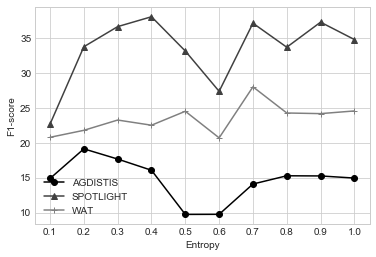

In [23]:

fig = plt.figure()
cnt=0
c=['o', '^', '+', '3', 'x']
clr=['0.0', '0.25', '0.5', '0.7', '0.8']


for system in systems:
    w=open('debug/entropy_%s.tsv' % system, 'w')
    w.write('ENTROPY\tFREQUENCY\tF1\tFORM\tINSTANCE\n')
    xs=[]
    ys=[]
    print(system.upper())
    for rentropy, forms_set in sorted(forms_per_rentropy.items()):
        prf=compute_macro_prf_on_selection(p[system], r[system], f1[system], forms_set)
        f1_sub=prf[2]
        for frm in sorted(list(forms_set)):
            interps=interpretations[frm]
            for i in interps:
                t=(frm, i)
                a='N/A'
                frq='N/A'
                if t in f1[system]:
                    a=f1[system][t]
                if frm in totals and i in totals[frm]:
                    frq=totals[frm][i]
                w.write('%f\t%s\t%f\t%s\t%s\n' % (round(rentropy,1), frq, a, frm, i))
                    
        w.write('\n')
        xs.append(rentropy)
        ys.append(f1_sub*100.0)
    plt.plot(xs, ys, "%s-" % c[cnt], color=clr[cnt], label=system.upper())
    cnt+=1
    w.close()
plt.legend()
plt.xlabel('Entropy')
plt.ylabel('F1-score')
plt.xticks(xs)
 
plt.show()

save=True
if save:
    fig.savefig('img/macro_entropy_f1.png')


**4.2. Compute correlation between form entropy and P/R/F1**

In [24]:
for metric in [prec_by_form, recall_by_form, f1_by_form]:
    for system in systems:
        print(system.upper())
    
        dist1, dist2 = analysis_utils.prepare_lists(metric[system], form_entropies)
        correlation, significance = spearmanr(dist1, dist2)
        print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: -0.10421059970832858 . Significance:  0.0188036189014617
SPOTLIGHT
The Spearman correlation between X and Y is: -0.0870835255272007 . Significance:  0.049802568586606345
WAT
The Spearman correlation between X and Y is: -0.09910142231899081 . Significance:  0.02550735470639067
AGDISTIS
The Spearman correlation between X and Y is: 0.03900293844200651 . Significance:  0.3803509356794377
SPOTLIGHT
The Spearman correlation between X and Y is: 0.04385657739895778 . Significance:  0.3238796097681437
WAT
The Spearman correlation between X and Y is: 0.02955449919112908 . Significance:  0.5062879242181675
AGDISTIS
The Spearman correlation between X and Y is: -0.03757070579581716 . Significance:  0.39810355580011614
SPOTLIGHT
The Spearman correlation between X and Y is: -0.015365677976072982 . Significance:  0.729724488056406
WAT
The Spearman correlation between X and Y is: -0.021289377675573533 . Significance:  0.6321446527659016


### 5) Correlation between instance ranks (of a form) and performance

<span style="background-color:lightgreen">Section 5.4. of the paper</span>


**5.1. Collect interpretations for a form**


In [25]:
interpretations=defaultdict(set)
for article in system_articles['spotlight']:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [26]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**5.2. Aggregate per rank**

In [27]:
def evaluate_ranks_macro(p, r, f1, rank_tuples):
    p_rank=defaultdict(list)
    r_rank=defaultdict(list)
    f1_rank=defaultdict(list)
    
    p_rank_avg={}
    r_rank_avg={}
    f1_rank_avg={}
    
    for rank, r_tuples in rank_tuples.items():
        for t in r_tuples:
            p_rank[rank].append(p[t])
            r_rank[rank].append(r[t])
            f1_rank[rank].append(f1[t])
    
    for rank in range(1,13):
        p_rank_avg[rank]=np.mean(p_rank[rank])
        r_rank_avg[rank]=np.mean(r_rank[rank])
        f1_rank_avg[rank]=np.mean(f1_rank[rank])
        
    return p_rank_avg, r_rank_avg, f1_rank_avg

In [28]:
def macro_rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=None, ambiguous_only=True, factor='freq'):

    print(factor)
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(14,3))
    p_rank={}
    r_rank={}
    f1_rank={}

    for system in systems:
        w=open('debug/%srank_%s.tsv' % (factor, system), 'w')
        rank_tuples=analysis_utils.prepare_ranks(system_articles[system], 
                                                  ambiguous_forms,
                                                  uri_pr=uri_pr,
                                                  ambiguous_only=ambiguous_only, 
                                                  factor=factor)
        for rank in sorted(rank_tuples.keys()):
            w.write('%d\n' % rank)
            for t in rank_tuples[rank]:
                w.write(' \t%s\t%s\n' % (t[0], t[1]))
            w.write('\n')
        w.close()
        #print(rank_tuples)
        p_rank[system], r_rank[system], f1_rank[system] = evaluate_ranks_macro(p[system], r[system], f1[system], 
                                                          rank_tuples)
        
        print()

    plot_utils.plot_prf(p_rank, systems, axs[0], title="PRECISION")
    plot_utils.plot_prf(r_rank, systems, axs[1], title="RECALL")
    plot_utils.plot_prf(f1_rank, systems, axs[2], title="F1-SCORE")

    plt.show()

    fig.savefig('img/accuracy_per_%s_rank.png' % factor, bbox_inches='tight')

freq



[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


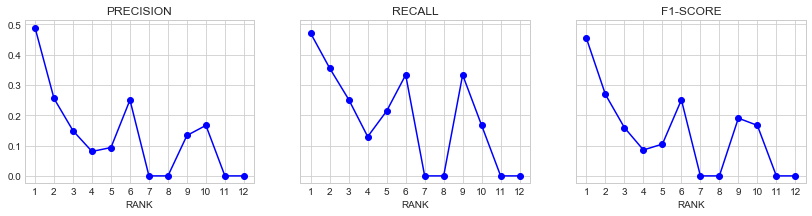

In [29]:
macro_rank_analysis(systems, system_articles, ambiguous_forms, ambiguous_only=True, factor='freq')

#### 5.3 PR ranks


pr



[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


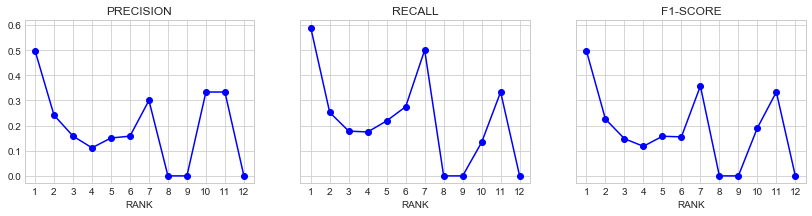

In [30]:
macro_rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=uri_pr, ambiguous_only=True, factor='pr')